In [1]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [3]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [4]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [5]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [6]:
df = get_samples(df,800000)

In [7]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [8]:
df.shape

(800000, 4)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [10]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
525161,5,Anyone else hate myspace?,I detest it with an extreme passion. For so ma...,i hate those obnoxious myspace whores and emo ...,Anyone else hate myspace?I detest it with an e...,Anyone else hate myspace?I detest it with an e...
342045,7,Why won't my parents let me grow up?,"Yeah..I do chores every weekend, I get good gr...",They must trust you pretty well if they are le...,Why won't my parents let me grow up?Yeah..I do...,Why won't my parents let me grow up?Yeah..I do...
360543,6,whitch team will win world cup?,,Brazil! :),whitch team will win world cup?,whitch team will win world cup?Brazil! :)
627589,6,Will Notre Dame win the national championship?,,NEVER rule them out!,Will Notre Dame win the national championship?,Will Notre Dame win the national championship?...
1106649,8,MadTV or Saturday Night Live ?,,MadTV.,MadTV or Saturday Night Live ?,MadTV or Saturday Night Live ?MadTV.


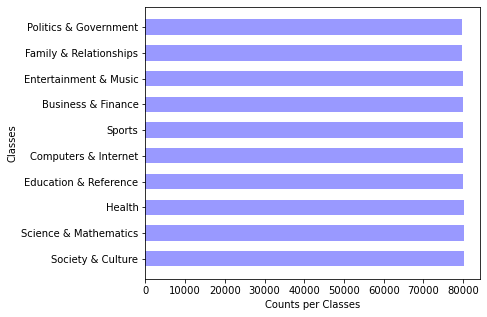

In [11]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [12]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [13]:
lst_stopwords = stopwords.words('english')

In [14]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [15]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [16]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
525161,5,Anyone else hate myspace?,I detest it with an extreme passion. For so ma...,i hate those obnoxious myspace whores and emo ...,Anyone else hate myspace?I detest it with an e...,Anyone else hate myspace?I detest it with an e...,anyone else hate myspace detest extreme passio...
342045,7,Why won't my parents let me grow up?,"Yeah..I do chores every weekend, I get good gr...",They must trust you pretty well if they are le...,Why won't my parents let me grow up?Yeah..I do...,Why won't my parents let me grow up?Yeah..I do...,parent let grow yeah chore every weekend get g...
360543,6,whitch team will win world cup?,,Brazil! :),whitch team will win world cup?,whitch team will win world cup?Brazil! :),whitch team win world cup brazil
627589,6,Will Notre Dame win the national championship?,,NEVER rule them out!,Will Notre Dame win the national championship?,Will Notre Dame win the national championship?...,notre dame win national championship never rule
1106649,8,MadTV or Saturday Night Live ?,,MadTV.,MadTV or Saturday Night Live ?,MadTV or Saturday Night Live ?MadTV.,madtv saturday night live madtv
62943,6,Who is the first bowler to take a hat-trick in...,,One Day Internationals - Hat Tricks\n\nJalal-u...,Who is the first bowler to take a hat-trick in...,Who is the first bowler to take a hat-trick in...,first bowler take hat trick one day internatio...
677112,9,Am I able to get the telephone number to DVI p...,,(209) 835-4141\nThere's the main phone number\...,Am I able to get the telephone number to DVI p...,Am I able to get the telephone number to DVI p...,able get telephone number dvi prison tracey ca...
633935,1,"In heaven, around God's throne, are four beast...","As the seals of the scroll are opened, each sp...",You can take or leave this answer as you see f...,"In heaven, around God's throne, are four beast...","In heaven, around God's throne, are four beast...",heaven around god throne four beast seal scrol...
378152,3,Has anyone ever Oxycise!d?,I am looking for POSITIVE feedback on Oxycisin...,"goto www.qigong ,www.authentic breathing or a...",Has anyone ever Oxycise!d?I am looking for POS...,Has anyone ever Oxycise!d?I am looking for POS...,anyone ever oxycise looking positive feedback ...
913601,5,how can we log on to Myspace when it is blocked?,,Do your myspace stuff from your home computer ...,how can we log on to Myspace when it is blocked?,how can we log on to Myspace when it is blocke...,log myspace blocked myspace stuff home compute...


In [17]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [18]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
525161,5,Anyone else hate myspace?,I detest it with an extreme passion. For so ma...,i hate those obnoxious myspace whores and emo ...,Anyone else hate myspace?I detest it with an e...,Anyone else hate myspace?I detest it with an e...,anyone else hate myspace detest extreme passio...,121,542,7,4.479339,17.285714
342045,7,Why won't my parents let me grow up?,"Yeah..I do chores every weekend, I get good gr...",They must trust you pretty well if they are le...,Why won't my parents let me grow up?Yeah..I do...,Why won't my parents let me grow up?Yeah..I do...,parent let grow yeah chore every weekend get g...,102,428,14,4.196078,7.285714


In [19]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

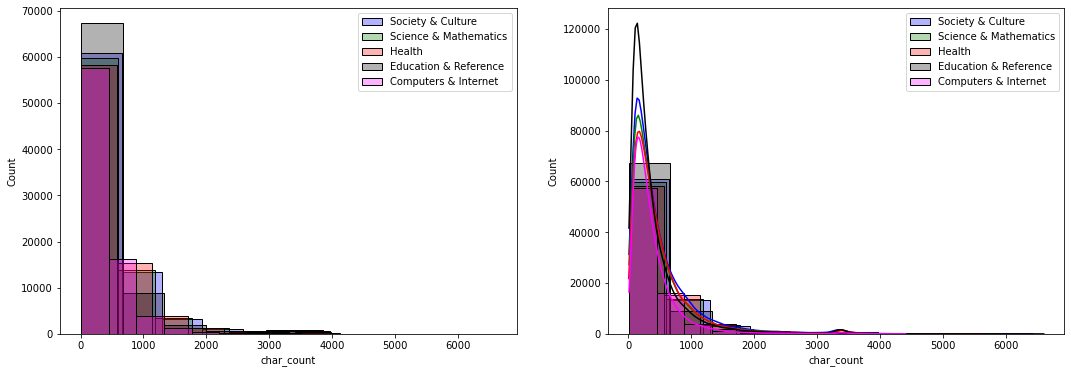

In [20]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [21]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     76
4     51
5     59
6     45
7     53
8     41
9     75
10    73
Name: word_count, dtype: int64

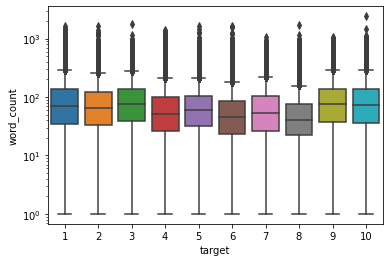

In [22]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

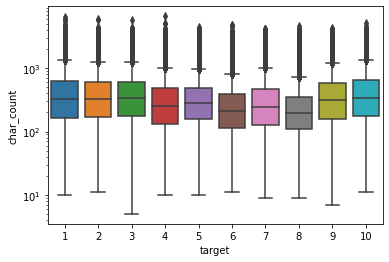

In [23]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

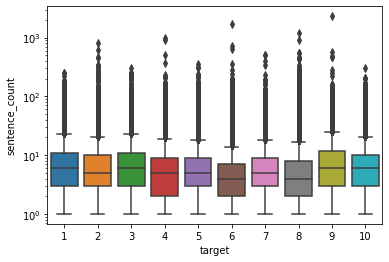

In [24]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

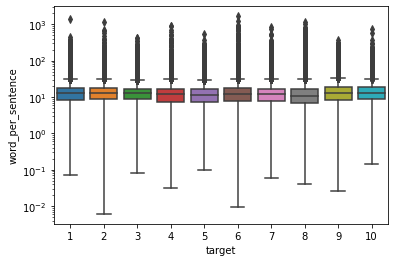

In [25]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [26]:
X = df.Text_new
y = df.target

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [28]:
vect = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

In [29]:
XX_train = vect.fit_transform(X_train)

In [30]:
XX_test = vect.transform(X_test)

In [31]:
vocab = vect.vocabulary_

In [32]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [33]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

4988

In [34]:
df_features.head(5)

,feature,Score,y
42,abraham,1.0,1
53,accent,1.0,1
54,accept,1.0,1
55,acceptable,1.0,1
59,according,1.0,1


In [35]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 3206
abraham,accent,accept,acceptable,according,account,acid,act,adam,address,african,african american,agree,allah,american,among,ancestor,ancient,angel,answer,application,arab,arabic,asian,atheist,bad thing,ball,basketball,beast,beautiful

category 2: Science & Mathematics
length of category 2: 3962
10,100,12,14,15,16,24,25,2x,3x,4x,5x,6x,absolute,absorbed,ac,acceleration,account,acid,adding,addition,address,advice,affect,air,aircraft,algebra,alien,alot,alpha

category 3: Health
length of category 3: 3682
ab,abnormal,account,acid,acne,active,activity,addicted,addiction,address,adult,advice,advise,affect,affected,afterwards,age,ago,aid,alcohol,allergic,allergy,alot,also,also help,alternative,america,american,amount,ankle

category 4: Education & Reference
length of category 4: 2866
2x,3x,5x,abroad,academic,accounting,activity,admission,aid,algebra,ancient,answer,ap,apply,applying,art,article,assignment,associate,attend,author,bachelor

In [36]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [37]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(720000, 4988)

In [38]:
XX_test = vect.transform(X_test)

In [39]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [40]:
# Creating a cloud of words

In [41]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [42]:
Text = " ".join(df_features[df_features.y==6].feature[:30])
Text

'1st 2nd 3rd account acid act address angeles animal answer anything application argentina arsenal ask association athlete atlanta au australia australian award ball band bank barrel baseball basket basketball bass'

In [43]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

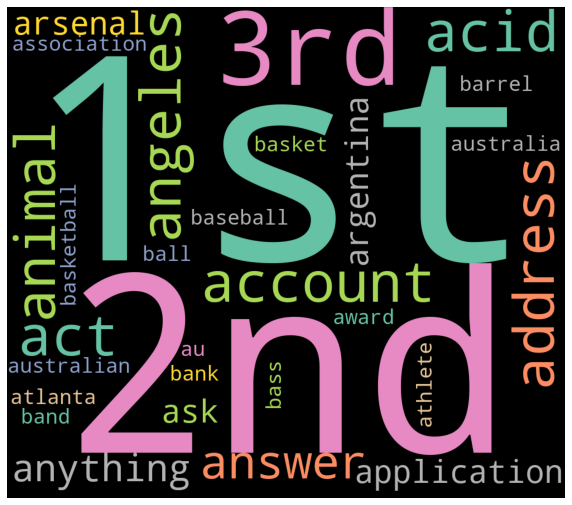

In [44]:
plot_cloud(wordcloud)

In [45]:
cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [46]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [47]:
nb = naive_bayes.MultinomialNB()

In [48]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [49]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6652111111111111

In [50]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [51]:
## Test Classifier
Predicted = nb.predict(XX_test)
Predicted_prob = nb.predict_proba(XX_test)

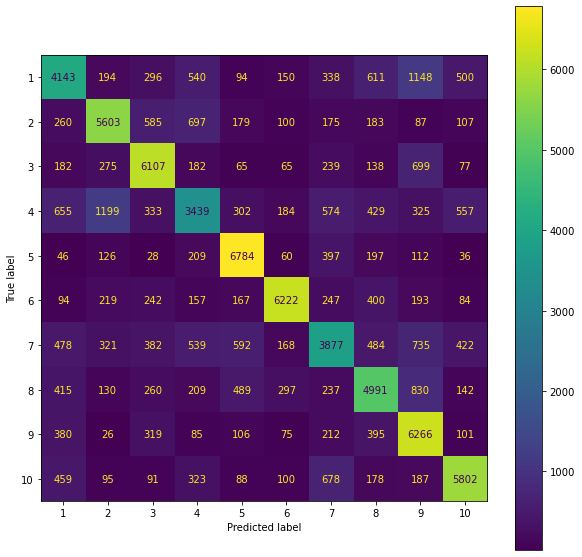

In [52]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

In [53]:
cross_val_score(nb,X_train_cvec,y_train,cv=5,n_jobs=-1).mean()

0.6592569444444444

## Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [54]:
model_lr = LogisticRegression(max_iter=5000)

In [55]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [56]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6873000000000001

In [57]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000)

In [58]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

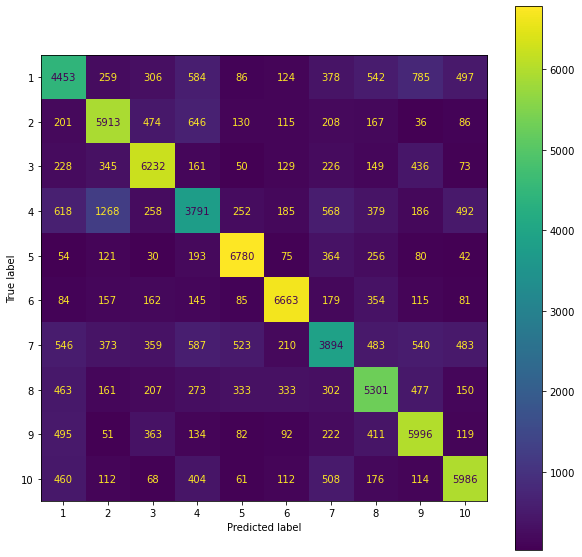

In [59]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

In [60]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

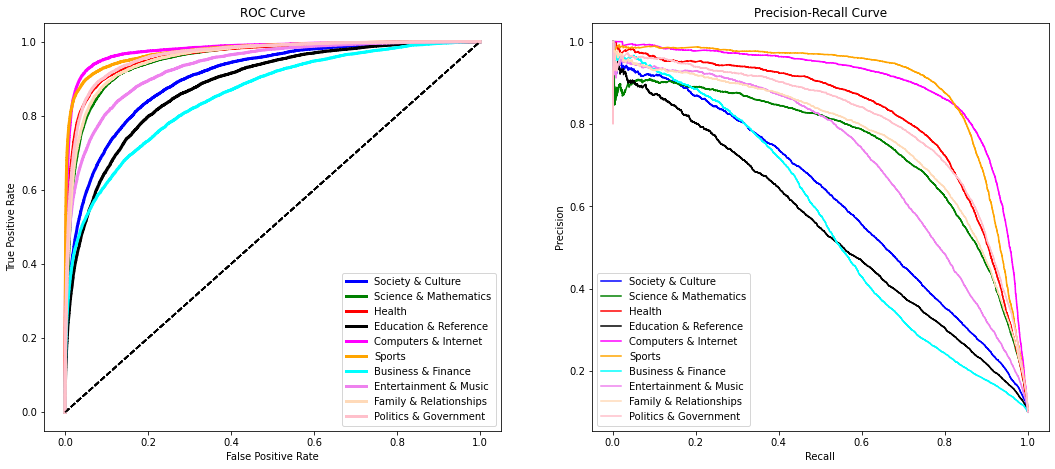

In [61]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()

## Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [62]:
model_rf = RandomForestClassifier(n_estimators=2000,max_depth=10,n_jobs=-1)

In [63]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [64]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.5227541666666667

In [65]:
model_rf.fit(XX_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=2000, n_jobs=-1)

In [66]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

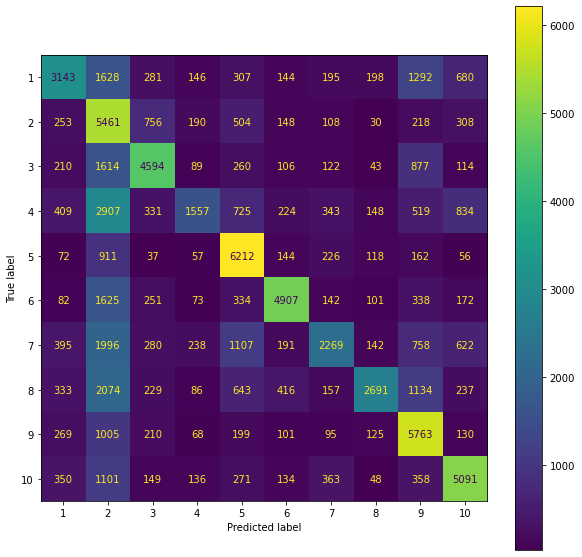

In [67]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

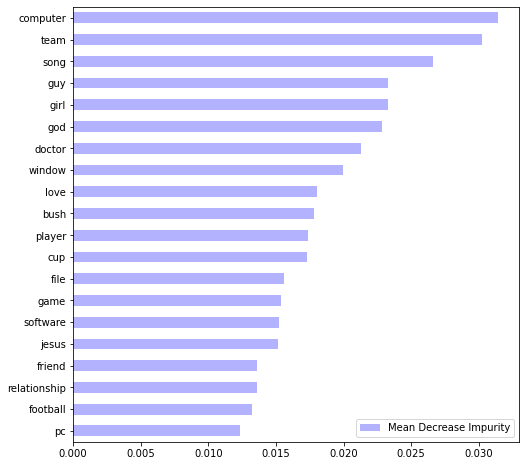

In [68]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')

### Binary Classification

### GridSearch CV

In [69]:
# opt_model = pipeline.Pipeline([
#            ('vectopt', TfidfVectorizer()),
#            ('classifier', model_lr)])

In [70]:
# parameters = {
#     'vectopt__max_df': (0.98, 1.0),
#     'vectopt__min_df': (0.01, 0.02 ),
#     'vectopt__max_features': (2000, 5000, 10000),
#     'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
#                 }

In [71]:
# # lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=2,verbose=1,scoring='accuracy',n_jobs=-1)
# lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=50)

In [72]:
# lr_gs.fit(X_train,y_train)

In [73]:
# e = pd.DataFrame(lr_gs.cv_results_)

In [74]:
# e.sort_values(by='mean_test_score',axis=0,ascending=False)

### USE THE BELOW LINES FOR DEBUGGING

In [75]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [76]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([  48887,   79152,  277508,  351312,  209846,  244377,   25227,
              48571,  243398,  261338,
            ...
             201299,  135767,  960400,  589632,   39215, 1005761,  340878,
             307277,  178367,  160550],
           dtype='int64', length=4104)

In [77]:
X_test[(y_test!=Predicted) & (y_test==7)]

48887      meet insane clown posse twiztid get hit ur chi...
79152      adding subrtacting fraction ok adding fraction...
277508     best form pollution free economical energy ide...
351312     good forum costco employee maybe space line ch...
209846     much love kill sure none brain may sing song f...
                                 ...                        
1005761    wish safest way take big amount money mexico n...
340878     state hottest economy getting sick michigan jo...
307277     think telling lie wrongdoing considered white ...
178367               funniest word fart heard barking spider
160550     one house chore stand hate putting clothes awa...
Name: Text_new, Length: 4104, dtype: object

In [78]:
X_test.loc[689499]

KeyError: 689499

In [ ]:
df.loc[689499]['Q&A']

In [ ]:
test_set = 55
text = X_test.iloc[test_set]
text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [ ]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [ ]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)